# Tutorial #3: Dataloading with `tensorflow-datasets` and PyTorch dataloading

We'll look at two ways to load datasets, `tensorflow-datasets` and pytorch dataloading. To illustrate, we'll use the MNIST dataset.

### 3.1: Tensorflow datasets data loading

We'll use `tensorflow-datasets`, which uses the function `tfds.load` to load datasets.

In [1]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
import matplotlib.pyplot as plt
tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_ds: tf.data.Dataset = tfds.load('mnist', split='train', data_dir='datasets/tensorflow_datasets')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test', data_dir='datasets/tensorflow_datasets')

`tfds` can be understood as a high-level wrapper around the `tensorflow` API `tf.data`.

In [2]:
assert isinstance(train_ds, tf.data.Dataset)
print(train_ds)
print(test_ds)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


Tensorflow datasets allow you to iterate over the examples in the dataset, with each example given as a dictionary.

In [3]:
for mnist_example in train_ds.take(1):
    print(mnist_example.keys())

dict_keys(['image', 'label'])


2025-02-03 15:13:58.529434: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


The MNIST images are handwritten digits, with labels from 0 through 9.

tf.Tensor(4, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


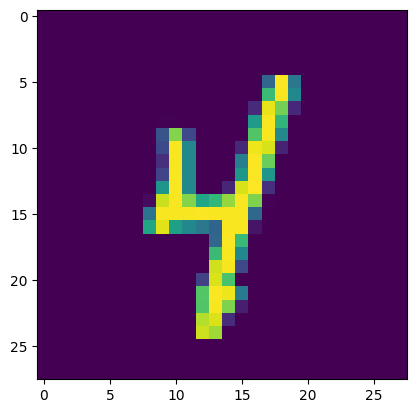

tf.Tensor(1, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


2025-02-03 15:13:58.599546: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


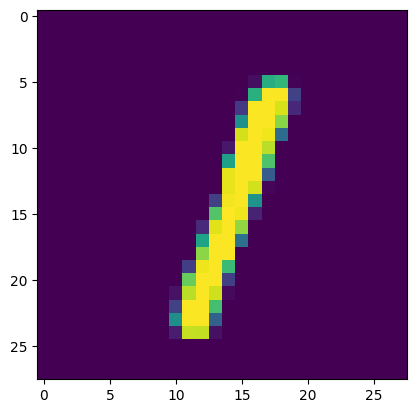

In [4]:
for mnist_example in train_ds.take(2):
    image = mnist_example['image']
    label = mnist_example['label']
    print(label)
    print(type(image))
    plt.imshow(image)
    plt.show()

We can see the size of our training and testing datasets using the `.cardinality()` function.

In [5]:
print(train_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())

60000
10000


Since the values of the pixels in each image range from 0 to 255, we'll normalize them to between 0 and 1 using the following lambda function.

In [6]:
# normalize train set
train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
) 
# Normalize test set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)

#### Improving dataset latency with `.prefetch(1)`

We can benchmark the speed of dataloading with `tfds` using `.benchmark()`. Apparently using `.prefetch(1)` improves the speed of data loading.

In [7]:
ds_benchmark_example_1 = train_ds.batch(32)

tfds.benchmark(ds_benchmark_example_1, batch_size=32)
tfds.benchmark(ds_benchmark_example_1, batch_size=32)  # Second epoch faster due to auto-caching


************ Summary ************



  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 66805.20 ex/sec (total: 60032 ex, 0.90 sec)
Examples/sec (First only) 482.68 ex/sec (total: 32 ex, 0.07 sec)
Examples/sec (First excluded) 72087.95 ex/sec (total: 60000 ex, 0.83 sec)

************ Summary ************



  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 176964.26 ex/sec (total: 60032 ex, 0.34 sec)
Examples/sec (First only) 1193.17 ex/sec (total: 32 ex, 0.03 sec)
Examples/sec (First excluded) 192053.52 ex/sec (total: 60000 ex, 0.31 sec)


,duration,num_examples,avg
first+lasts,0.339232,60032,176964.263082
first,0.026819,32,1193.165385
lasts,0.312413,60000,192053.518709


In [8]:
ds_benchmark_example_2 = train_ds.batch(32).prefetch(1)

tfds.benchmark(ds_benchmark_example_2, batch_size=32)
tfds.benchmark(ds_benchmark_example_2, batch_size=32)  # Second epoch faster due to auto-caching


************ Summary ************



  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 199795.85 ex/sec (total: 60032 ex, 0.30 sec)
Examples/sec (First only) 2377.40 ex/sec (total: 32 ex, 0.01 sec)
Examples/sec (First excluded) 209054.41 ex/sec (total: 60000 ex, 0.29 sec)

************ Summary ************



  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 188515.48 ex/sec (total: 60032 ex, 0.32 sec)
Examples/sec (First only) 1212.91 ex/sec (total: 32 ex, 0.03 sec)
Examples/sec (First excluded) 205435.07 ex/sec (total: 60000 ex, 0.29 sec)


,duration,num_examples,avg
first+lasts,0.318446,60032,188515.478291
first,0.026383,32,1212.906063
lasts,0.292063,60000,205435.070341


In this example, using `.prefetch(1)` doesn't seem to make much of a differrence.

#### Data loading with `tfds` method 1: Prespecified number of training iterations 

We want to load our data either with a given batch size for a certain number of epochs or with a certain number of training iterations. We'll start by loading our data with a prespecified number of training iterations.

We'll load the dataset with 1000 training iterations and a batch size of 32, for a total of 32000 training examples.

We'll start by reloading the dataset indefinitely using the `.repeat()` function. We then shuffle the dataset using a buffer size of 1024. To explain the `.shuffle()` function, see [this](https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset) StackOverflow post.

In [9]:
train_steps = 1000
batch_size = 32

In [10]:
train_ds_1 = train_ds.repeat().shuffle(buffer_size = 1024) 

We can now take data indefinitely from our dataset. But we'll want to fetch data with a batch size of 32. For this, we'll use the functions `.batch(batch_size)` and the `.take(train_steps)`. We'll also use the `.prefetch(1)` function which apparently improves the latency of the dataset loading.

In [11]:
train_ds_1 = train_ds_1.batch(batch_size, drop_remainder=True)
train_ds_1 = train_ds_1.take(train_steps)
train_ds_1 = train_ds_1.prefetch(1)

We can now iterate over our dataset by converting the dataset to a numpy iterator, using the `.as_numpy_iterator()` function.

In [12]:
for step, batch in enumerate(train_ds_1.as_numpy_iterator()):
    pass
    
print(step)
print(batch['image'].shape)
print(batch['label'].shape)

999
(32, 28, 28, 1)
(32,)


As you can see, we've performed 1000 iterations over the dataset and each dataset has a batch size of 32. As we wanted!

#### Data loading with `tfds` method 2: Prespecified number of epochs

We'll now perform a pre-specified number of epochs over the dataset. Instead of repeating an indefinite number of times, then batching, we'll need to batch our dataset first, then repeat `num_epochs` times. We'll also want to shuffle first, as this ensures that the batches in each epoch are different.  

In [13]:
batch_size = 32
num_epochs = 5

In [14]:
train_ds_2 = train_ds.shuffle(buffer_size = 1024).batch(batch_size, drop_remainder=True).repeat(num_epochs).prefetch(1)

In [15]:
counter = 0
for step, batch in enumerate(train_ds_2.as_numpy_iterator()):
    counter += 1
print(counter)
print(batch['image'].shape)
print(batch['label'].shape)

9375
(32, 28, 28, 1)
(32,)


We've now performed 5 epochs over the dataset, as desired.

### 3.2: PyTorch data loading

Loading datasets using PyTorch's `Dataloader` function is easy. We'll first import MNIST using `torchvision`. 

In [16]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [17]:
training_data = datasets.MNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor()
)

We then convert the data into a `DataLoader` object, with a given batch size.  

In [18]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

We can then iterate over the `DataLoader` objects.

In [19]:
for step, (train_features, train_labels) in enumerate(train_dataloader):
    pass
print(step)
print(train_features.shape)
print(train_labels.shape)

937
torch.Size([32, 1, 28, 28])
torch.Size([32])


It looks like, if we want to convert these to numpy arrays, we'll have to manually convert them.